In [22]:
import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt


In [23]:
data = pd.read_csv('../datasets/complete_data/df.csv')
data = data.rename(columns={'start MTU (UTC)': 'ds', 'Day-ahead Price [EUR/MWh] BZN|NO1': 'y'})
X = data.drop(['y', 'ds'], axis=1)
y = data['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


In [24]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)
y_train = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test = scaler_y.transform(y_test.values.reshape(-1, 1)).ravel()

In [25]:
param_grid = {"C": [0.1, 1, 10], "gamma": ["scale", "auto", 0.1, 1]}
grid_search = GridSearchCV(SVR(kernel="rbf"), param_grid, cv=5)
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': [0.1, 1, 10], 'gamma': ['scale', 'auto', 0.1, 1]})

In [26]:
y_pred = grid_search.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

Mean Absolute Error: 0.05346661861932


In [27]:
def plot_true_vs_predicted(y_true, y_pred):
    plt.figure(figsize=(10, 6))
    plt.plot(y_true, label="True Values", color='blue', linestyle='-', linewidth=2)
    plt.plot(y_pred, label="Predicted Values", color='red', linestyle='--', linewidth=2)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.title("True vs. Predicted Values")
    plt.show()

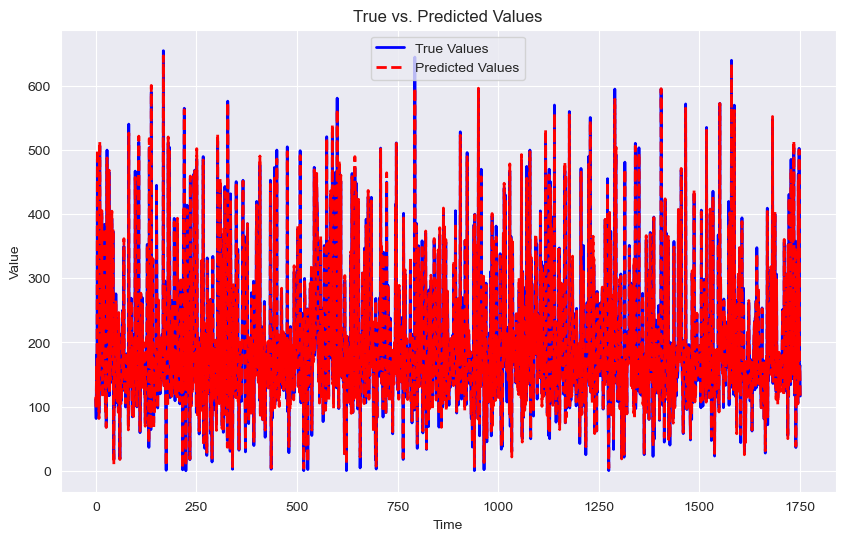

In [28]:
# Inverse transform the scaled values to their original scale
y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler_y.inverse_transform(y_pred.reshape(-1, 1))

plot_true_vs_predicted(y_test_inv, y_pred_inv)

THe plot is too cluttered, as such I will try to

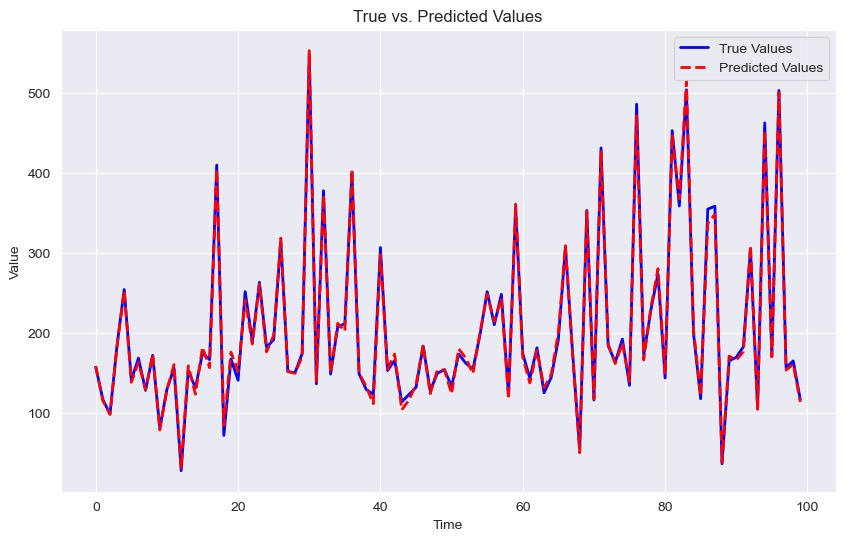

In [29]:
subset_size = 100  # Choose the number of data points you want to visualize
y_test_subset = y_test_inv[-subset_size:]
y_pred_subset = y_pred_inv[-subset_size:]

plot_true_vs_predicted(y_test_subset, y_pred_subset)

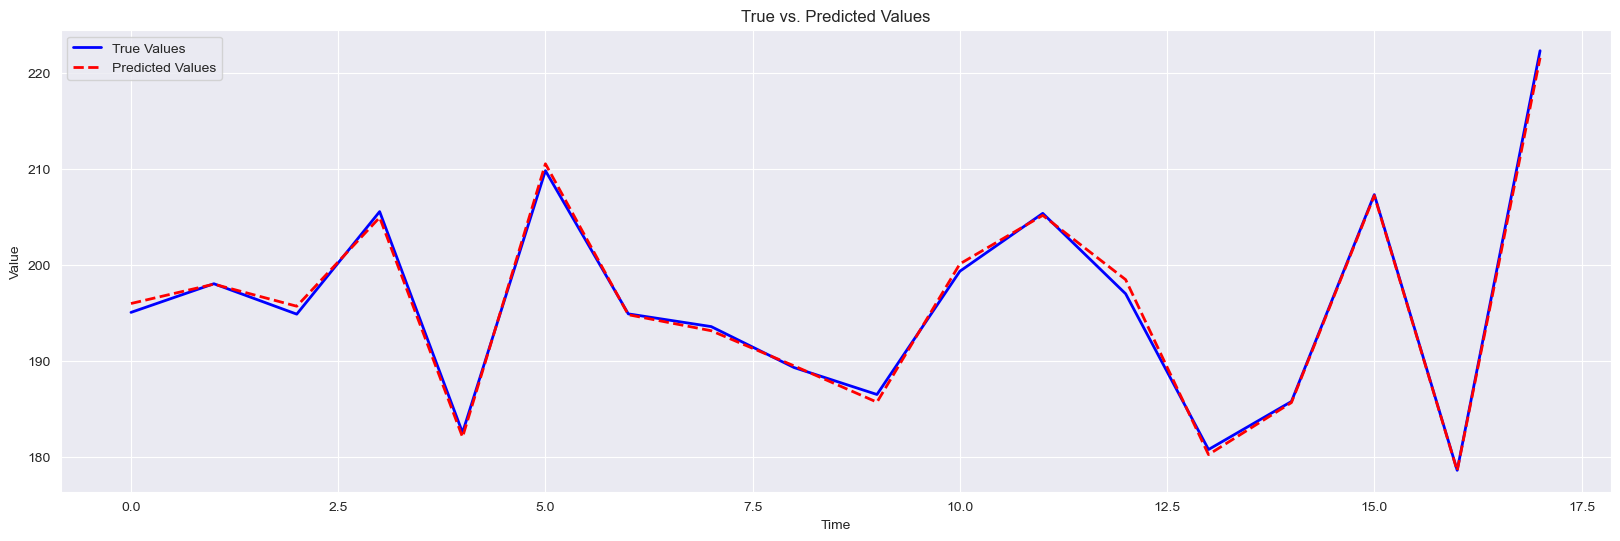

In [39]:
def aggregate_data(data, window_size, agg_func=np.mean):
    aggregated_data = []
    for i in range(0, len(data), window_size):
        aggregated_data.append(agg_func(data[i:i + window_size]))
    return np.array(aggregated_data)

# Choose the aggregation window size and function
window_size = 100  # Choose the number of data points to aggregate
agg_func = np.mean  # You can use other aggregation functions like np.median, np.sum, etc.

y_test_agg = aggregate_data(y_test_inv, window_size, agg_func)
y_pred_agg = aggregate_data(y_pred_inv, window_size, agg_func)

plot_true_vs_predicted(y_test_agg, y_pred_agg)

In [34]:
def plot_true_vs_predicted(y_true, y_pred):
    plt.figure(figsize=(20, 6))  # Adjust the width value to make the plot wider
    plt.plot(y_true, label="True Values", color='blue', linestyle='-', linewidth=2)
    plt.plot(y_pred, label="Predicted Values", color='red', linestyle='--', linewidth=2)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.title("True vs. Predicted Values")
    plt.show()

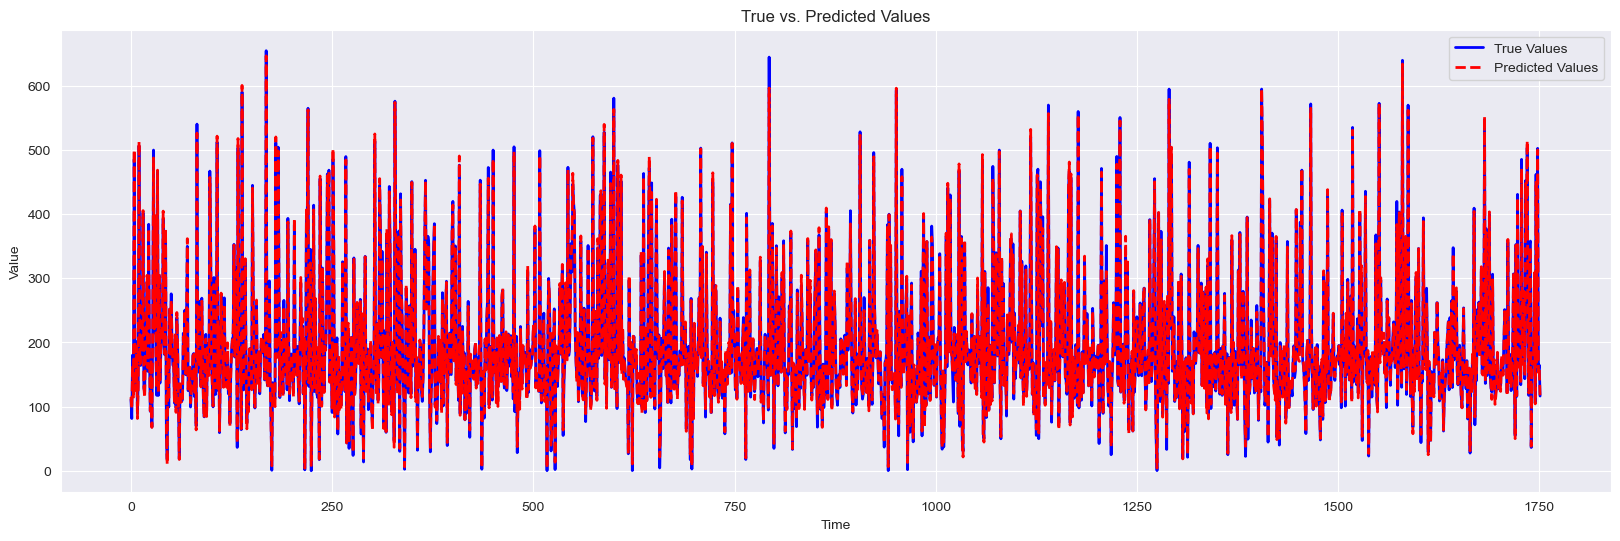

In [35]:
plot_true_vs_predicted(y_test_inv, y_pred_inv)

This data doesn't have the X-axis showing the time frame so I will implement that next.

In [40]:
# Create a DataFrame with true and predicted values
result_df = pd.DataFrame({'True': y_test_inv.ravel(), 'Predicted': y_pred_inv.ravel()}, index=data.iloc[-len(y_test_inv):]['ds'])

# Convert the index to a DateTimeIndex
result_df.index = pd.to_datetime(result_df.index)

In [41]:
def plot_true_vs_predicted_time_index(df):
    plt.figure(figsize=(15, 6))
    plt.plot(df.index, df['True'], label="True Values", color='blue', linestyle='-', linewidth=2)
    plt.plot(df.index, df['Predicted'], label="Predicted Values", color='red', linestyle='--', linewidth=2)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.title("True vs. Predicted Values")
    plt.xticks(rotation=45)
    plt.show()


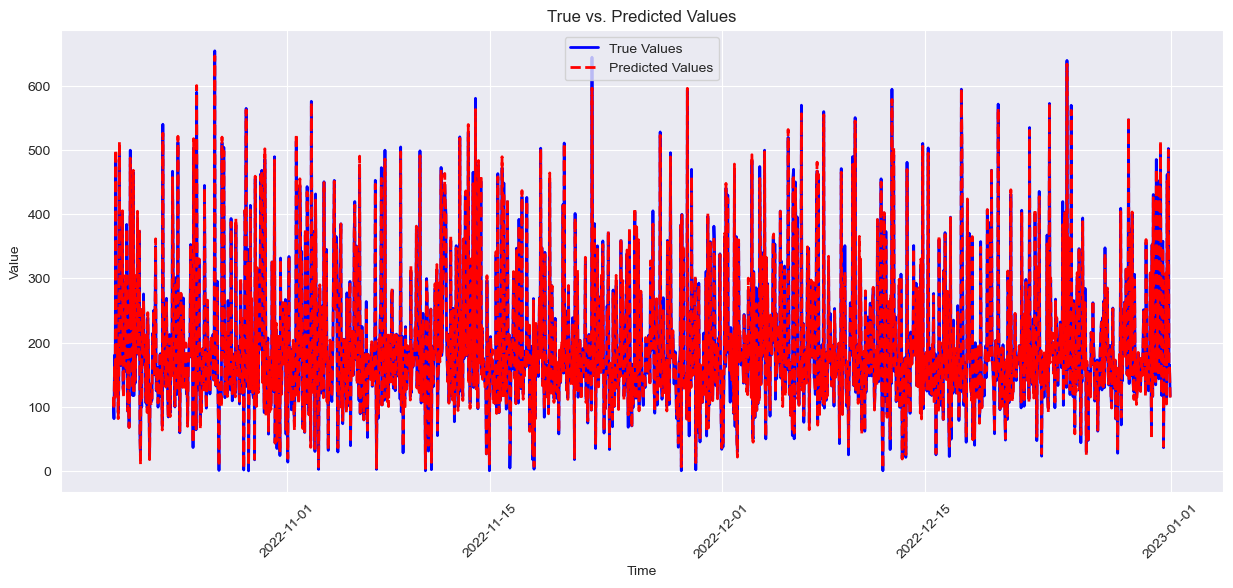

In [42]:
plot_true_vs_predicted_time_index(result_df)

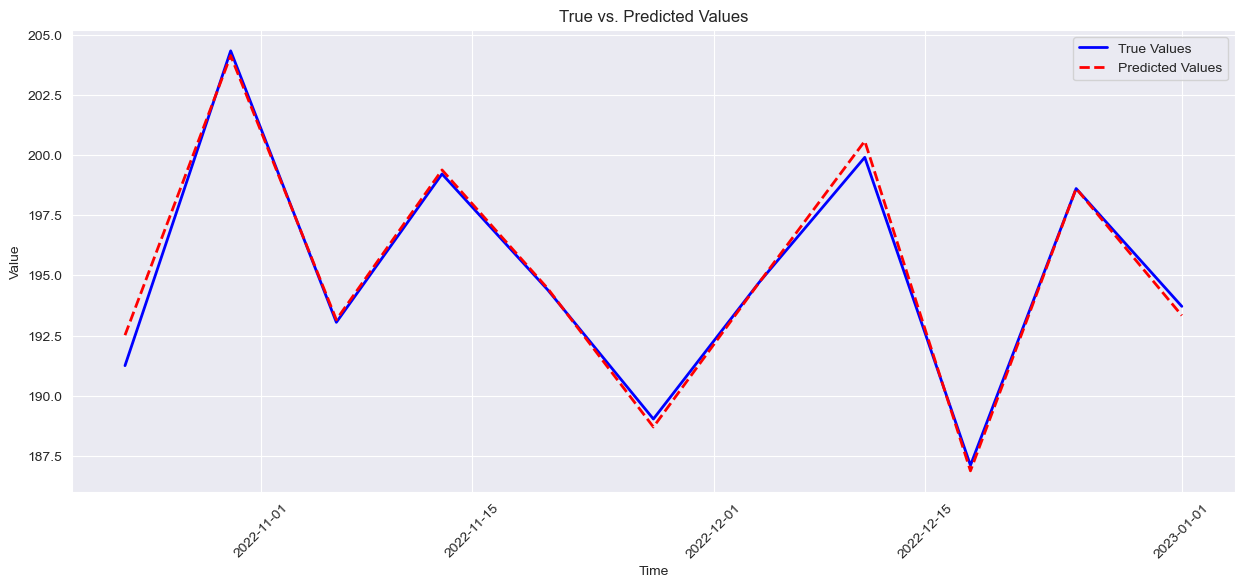

In [52]:
# Define a function to resample the data using a custom aggregation function (e.g., mean)
def resample_data(data, freq, agg_func='mean'):
    return data.resample(freq).agg(agg_func)

# Choose the aggregation frequency and function
agg_freq = 'W'  # Daily aggregation
agg_func = 'mean'  # You can use other aggregation functions like 'median', 'sum', etc.

result_df_agg = resample_data(result_df, agg_freq, agg_func)

plot_true_vs_predicted_time_index(result_df_agg)
